In [22]:
import re
import pandas as pd
import numpy as np
import urllib.request
import zipfile
import urllib.request
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.metrics import mutual_info_score, accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [23]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
url = 'https://archive.ics.uci.edu/static/public/222/bank+marketing.zip'
urllib.request.urlretrieve(url, 'bank_marketing.zip')

('bank_marketing.zip', <http.client.HTTPMessage at 0x28813b7d550>)

In [25]:
with zipfile.ZipFile('bank_marketing.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [26]:
with zipfile.ZipFile('bank.zip', 'r') as zip_ref:
    zip_ref.extractall()

In [27]:
data = pd.read_csv('bank-full.csv', sep=';')
data.head() 

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


In [28]:
# Select only the required columns
features = [
    'age', 'job', 'marital', 'education', 'balance', 'housing', 'contact',
    'day', 'month', 'duration', 'campaign', 'pdays', 'previous', 'poutcome', 'y'
]
data = data[features]

# Convert the target variable 'y' to binary (1 for 'yes', 0 for 'no')
data['y'] = (data['y'] == 'yes').astype(int)

# Split the data into train, validation, and test sets (60%/20%/20%)
SEED = 1
df_full_train, df_test = train_test_split(data, test_size=0.2, random_state=SEED)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=SEED)  # 0.25 of 80% = 20%

# Split target variable
y_train = df_train['y'].values
y_val = df_val['y'].values
y_test = df_test['y'].values

# Remove the target column from the feature sets
df_train = df_train.drop('y', axis=1)
df_val = df_val.drop('y', axis=1)
df_test = df_test.drop('y', axis=1)

In [29]:
from sklearn.metrics import roc_auc_score

# List of numerical features
numerical_features = ['balance', 'day', 'duration', 'previous']

# Initialize a dictionary to store AUC values
auc_scores = {}

# Compute AUC for each numerical feature
for feature in numerical_features:
    # Calculate the AUC score
    auc = roc_auc_score(y_train, df_train[feature])
    
    # If AUC is less than 0.5, invert the feature
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[feature])
    
    # Store the AUC score
    auc_scores[feature] = auc

# Find the feature with the highest AUC
highest_auc_feature = max(auc_scores, key=auc_scores.get)

# Print AUC scores and the feature with the highest AUC
print(auc_scores)
print(f'The numerical feature with the highest AUC is: {highest_auc_feature}')


{'balance': np.float64(0.5888313805382317), 'day': np.float64(0.525957882383908), 'duration': np.float64(0.8147002759670778), 'previous': np.float64(0.5985653242764153)}
The numerical feature with the highest AUC is: duration


### Q.2

In [30]:
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score

# Convert training and validation data to dictionary format for DictVectorizer
train_dict = df_train.to_dict(orient='records')
val_dict = df_val.to_dict(orient='records')

# Initialize DictVectorizer and transform the datasets
dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dict)
X_val = dv.transform(val_dict)

# Train the logistic regression model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000, random_state=1)
model.fit(X_train, y_train)

# Make predictions on the validation set (use predict_proba to get probabilities)
y_pred_val = model.predict_proba(X_val)[:, 1]

# Calculate the AUC score
auc_val = roc_auc_score(y_val, y_pred_val)

# Round the AUC score to 3 decimal places
auc_val_rounded = round(auc_val, 3)

print(f'AUC on the validation dataset: {auc_val_rounded}')


AUC on the validation dataset: 0.901


### Q.3

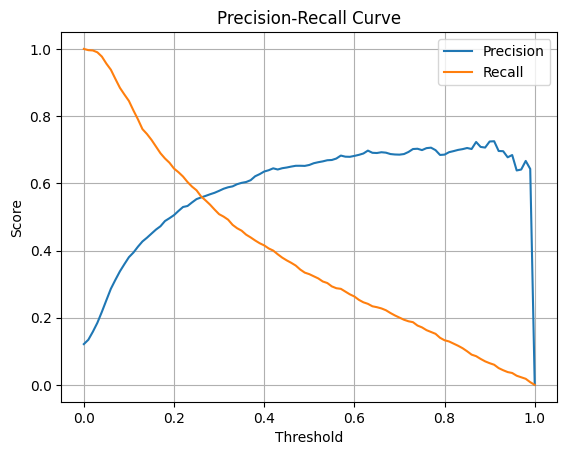

Precision and Recall curves intersect at threshold: 1.000


In [31]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

# Use the predicted probabilities on the validation set from the logistic regression model
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Create lists to store precision and recall for each threshold
thresholds = np.arange(0.0, 1.01, 0.01)
precisions = []
recalls = []

# Loop through the thresholds
for t in thresholds:
    # Predict the labels based on the threshold
    y_pred_threshold = (y_pred_proba >= t).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_pred_threshold)
    recall = recall_score(y_val, y_pred_threshold)
    
    # Store precision and recall
    precisions.append(precision)
    recalls.append(recall)

# Convert lists to numpy arrays for plotting
precisions = np.array(precisions)
recalls = np.array(recalls)

# Plot precision and recall curves
plt.plot(thresholds, precisions, label='Precision')
plt.plot(thresholds, recalls, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision-Recall Curve')
plt.legend()
plt.grid(True)
plt.show()

# Find the intersection point (where precision is closest to recall)
intersection_idx = np.argmin(np.abs(precisions - recalls))
intersection_threshold = thresholds[intersection_idx]

print(f'Precision and Recall curves intersect at threshold: {intersection_threshold:.3f}')


### Q.4

In [32]:
import numpy as np
from sklearn.metrics import precision_score, recall_score

# Use the predicted probabilities on the validation set from the logistic regression model
y_pred_proba = model.predict_proba(X_val)[:, 1]

# Create lists to store F1 scores and thresholds
thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

# Loop through the thresholds
for t in thresholds:
    # Predict the labels based on the threshold
    y_pred_threshold = (y_pred_proba >= t).astype(int)
    
    # Calculate precision and recall
    precision = precision_score(y_val, y_pred_threshold)
    recall = recall_score(y_val, y_pred_threshold)
    
    # Calculate F1 score using the formula
    if precision + recall > 0:
        f1 = 2 * (precision * recall) / (precision + recall)
    else:
        f1 = 0
    
    # Store the F1 score
    f1_scores.append(f1)

# Convert F1 scores to numpy array for easier handling
f1_scores = np.array(f1_scores)

# Find the threshold with the maximum F1 score
max_f1_idx = np.argmax(f1_scores)
max_f1_threshold = thresholds[max_f1_idx]

# Output the threshold with the maximum F1 score
print(f'Threshold with maximum F1 score: {max_f1_threshold:.2f}')


Threshold with maximum F1 score: 0.22


### Q.5

In [33]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize a list to store AUC scores for each fold
auc_scores = []

# Iterate over each fold
for train_idx, val_idx in kf.split(df_full_train):
    # Split the data into training and validation sets
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]
    
    # Separate the target variable
    y_train_fold = df_train_fold['y'].values
    y_val_fold = df_val_fold['y'].values
    df_train_fold = df_train_fold.drop('y', axis=1)
    df_val_fold = df_val_fold.drop('y', axis=1)
    
    # Apply one-hot encoding using DictVectorizer
    dv = DictVectorizer(sparse=False)
    train_dict = df_train_fold.to_dict(orient='records')
    val_dict = df_val_fold.to_dict(orient='records')
    
    X_train_fold = dv.fit_transform(train_dict)
    X_val_fold = dv.transform(val_dict)
    
    # Train the logistic regression model
    model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model.fit(X_train_fold, y_train_fold)
    
    # Predict probabilities on the validation set
    y_pred_val_fold = model.predict_proba(X_val_fold)[:, 1]
    
    # Calculate the AUC score
    auc = roc_auc_score(y_val_fold, y_pred_val_fold)
    
    # Append the AUC score to the list
    auc_scores.append(auc)

# Convert auc_scores to a numpy array for easier calculation
auc_scores = np.array(auc_scores)

# Calculate the standard deviation of the AUC scores
std_auc = np.std(auc_scores)

# Print the standard deviation of AUC scores
print(f'Standard deviation of AUC scores across folds: {std_auc:.6f}')


Standard deviation of AUC scores across folds: 0.005691


### Q.6

In [35]:
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import roc_auc_score
import numpy as np

# List of C values to iterate over
C_values = [0.000001, 0.001, 1]

# Initialize KFold with 5 splits
kf = KFold(n_splits=5, shuffle=True, random_state=1)

# Initialize a dictionary to store mean and std for each C value
scores_summary = {}

In [36]:
# Iterate over each C value
for C in C_values:
    auc_scores = []
    
    # Perform cross-validation
    for train_idx, val_idx in kf.split(df_full_train):
        # Split the data into training and validation sets
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]
        
        # Separate the target variable
        y_train_fold = df_train_fold['y'].values
        y_val_fold = df_val_fold['y'].values
        df_train_fold = df_train_fold.drop('y', axis=1)
        df_val_fold = df_val_fold.drop('y', axis=1)
        
        # Apply one-hot encoding using DictVectorizer
        dv = DictVectorizer(sparse=False)
        train_dict = df_train_fold.to_dict(orient='records')
        val_dict = df_val_fold.to_dict(orient='records')
        
        X_train_fold = dv.fit_transform(train_dict)
        X_val_fold = dv.transform(val_dict)
        
        # Train the logistic regression model with current C
        model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
        model.fit(X_train_fold, y_train_fold)
        
        # Predict probabilities on the validation set
        y_pred_val_fold = model.predict_proba(X_val_fold)[:, 1]
        
        # Calculate the AUC score
        auc = roc_auc_score(y_val_fold, y_pred_val_fold)
        
        # Append the AUC score to the list
        auc_scores.append(auc)
    
    # Compute mean and std of AUC scores for current C
    mean_auc = np.mean(auc_scores)
    std_auc = np.std(auc_scores)
    
    # Store mean and std in the dictionary
    scores_summary[C] = (round(mean_auc, 3), round(std_auc, 3))


In [37]:
# Print the results
for C, (mean_auc, std_auc) in scores_summary.items():
    print(f'C={C}: Mean AUC={mean_auc}, Std AUC={std_auc}')

# Find the C with the best mean AUC score
best_C = min(scores_summary, key=lambda x: (-scores_summary[x][0], scores_summary[x][1]))

print(f'The best C is: {best_C}')

C=1e-06: Mean AUC=0.701, Std AUC=0.009
C=0.001: Mean AUC=0.861, Std AUC=0.007
C=1: Mean AUC=0.906, Std AUC=0.006
The best C is: 1
